# Library

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf


# 한글 설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='white')

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[1], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# LSTM all fit - Best Model Saving

In [7]:
from tensorflow import keras
from sklearn import metrics 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import sklearn

path = '/project/LSH/'
with tf.device('/device:GPU:0'):

    x = np.load(path + 'x_(7727,10,4068).npy')
    y = np.load(path + 'y_(7727,1).npy')

    # LSTM model
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))

    # Best model saving
    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '/seed42-{epoch:02d}-val_loss:{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
    
    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    lstm.fit(x, y, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop, cb_checkpoint], shuffle=False)

Epoch 1/500
46/46 [==============================] - 6s 66ms/step - loss: 0.6458 - acc: 0.6511 - val_loss: 0.6934 - val_acc: 0.4865

Epoch 00001: val_loss improved from inf to 0.69343, saving model to ./model/f3595-01-val_loss:0.6934.hdf5
Epoch 2/500
46/46 [==============================] - 3s 56ms/step - loss: 0.6740 - acc: 0.6069 - val_loss: 0.7236 - val_acc: 0.4865

Epoch 00002: val_loss did not improve from 0.69343
Epoch 3/500
46/46 [==============================] - 3s 56ms/step - loss: 0.6650 - acc: 0.6419 - val_loss: 0.7360 - val_acc: 0.4865

Epoch 00003: val_loss did not improve from 0.69343
Epoch 4/500
46/46 [==============================] - 3s 56ms/step - loss: 0.6361 - acc: 0.6518 - val_loss: 0.6831 - val_acc: 0.4865

Epoch 00004: val_loss improved from 0.69343 to 0.68311, saving model to ./model/f3595-04-val_loss:0.6831.hdf5
Epoch 5/500
46/46 [==============================] - 3s 56ms/step - loss: 0.5297 - acc: 0.7406 - val_loss: 0.5721 - val_acc: 0.7107

Epoch 00005: val_

In [9]:
# 저장된 모델의 정확도 확인 (all fit이어서 정확도 높음)
x = np.load('/project/LSH/x_(7727,10,4068).npy')
model = tf.keras.models.load_model('/project/LSH/국내논문_한국정보과학회/model/seed42-06-val_loss:0.5523.hdf5')
pred = model.predict(x)
pred[pred>0.5] = 1
pred[pred<=0.5] = 0
metrics.accuracy_score(y, pred)

0.7981105215478194

In [10]:
# 저장된 모델의 정확도 확인 (all fit이어서 정확도 높음)
# f3595
x = np.load('x_(7727,10,3595).npy')
model = tf.keras.models.load_model('/project/LSH/국내논문_한국정보과학회/model/f3595-06-val_loss:0.5522.hdf5')
pred = model.predict(x)
pred[pred>0.5] = 1
pred[pred<=0.5] = 0
metrics.accuracy_score(y, pred)

0.8004400155299599

# M1 - 사망 / 생존 마커 TOP10
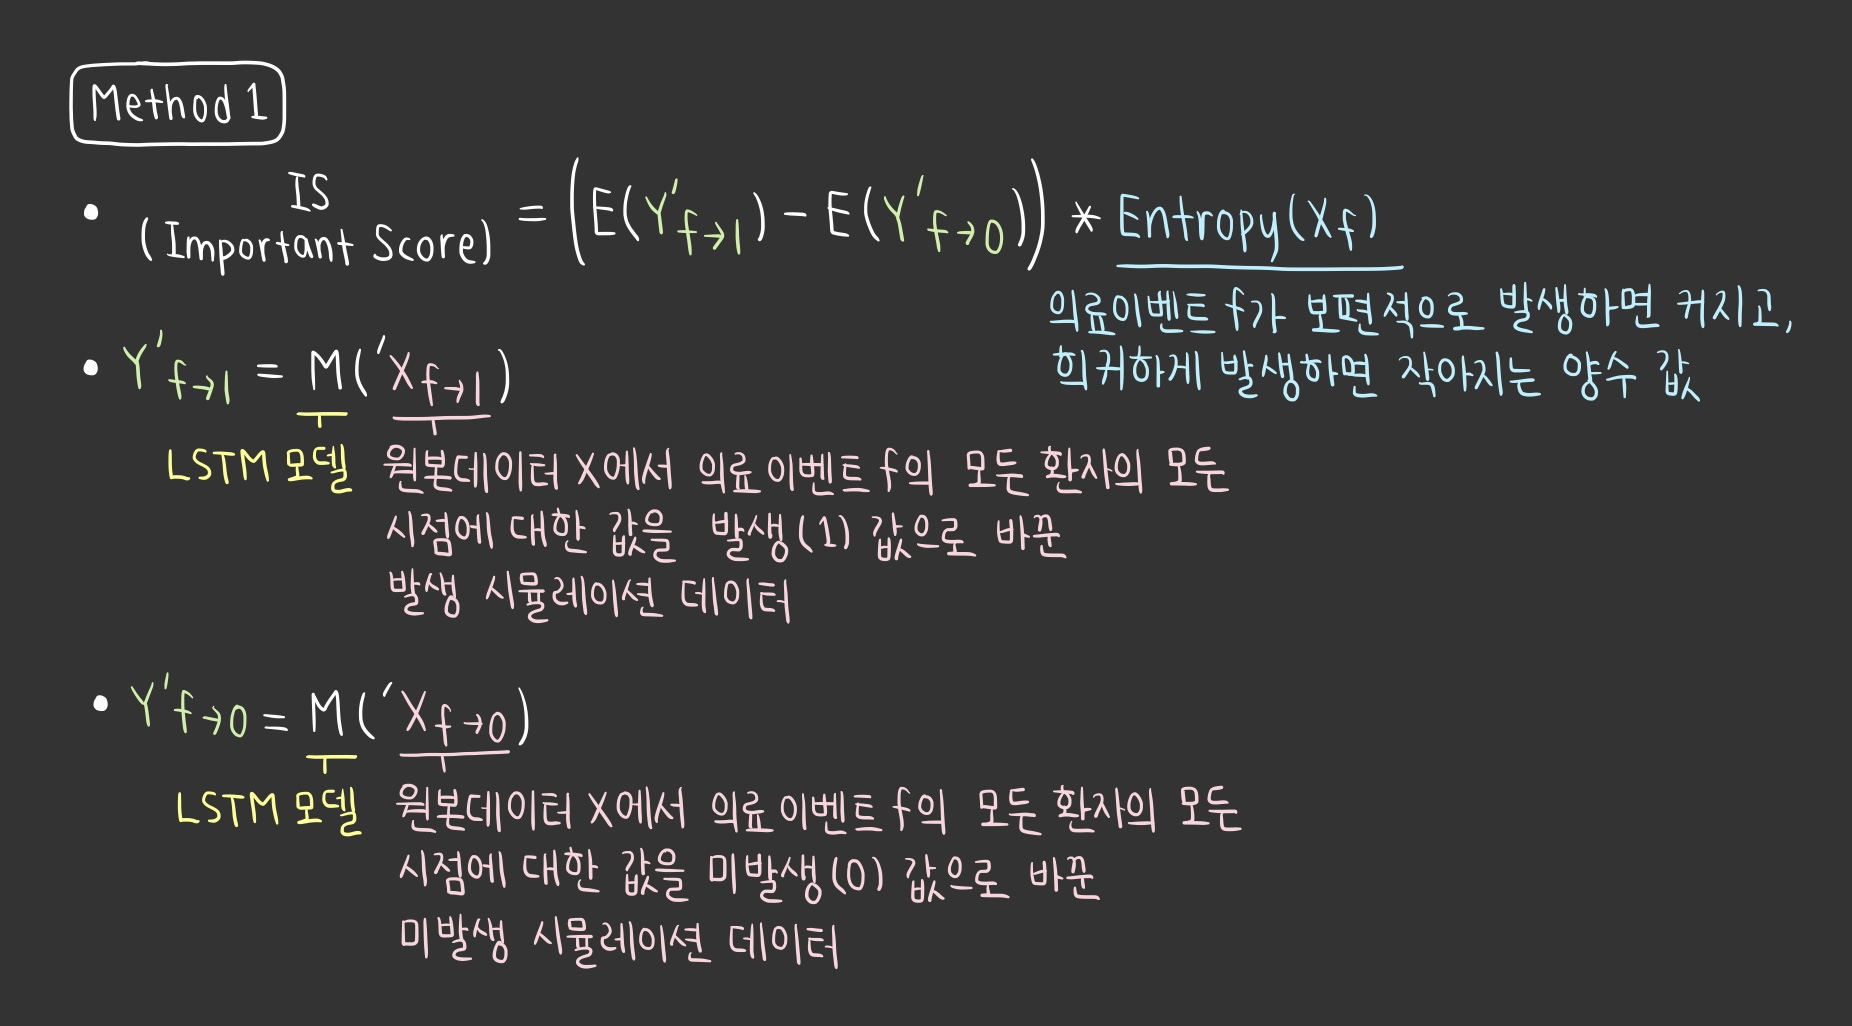

## Entropy
- [엔트로피에 대한 설명](https://datascienceschool.net/02%20mathematics/10.01%20%EC%97%94%ED%8A%B8%EB%A1%9C%ED%94%BC.html)
- 엔트로피(entropy)는 확률분포가 가지는 정보의 확신도 혹은 정보량을 수치로 표현한 것임
- 여러가지 값이 나올 확률이 대부분 비슷한 경우에 엔트로피가 높아짐 -> 보편성의 수치화

## Issue
- `total_data_7727.csv`는 4069개의 itemid를 포함하는데 실질적으로 x를 만들 때 feature에 하나라도 1의 값을 가진 feature 개수는 3595개임
- 0 to 1, 1 to 0을 하는 작업이 실질적으로 의미가 없는 feature가 (4069-3595) = 474개
- 474개 대한 정보가 반영되면 안되는 이유가 474개는 환자의 사망일로부터 10일 내의 데이터가 아니기 때문에 m1을 쓴다는 것 자체가 아이러니임
- 이 474개의 feature를 제외한 `total_data_7727_10_3595.csv`를 생성해서 실험해보자 (3.3 x_(7727, 10, 3595)에 해당 내용 기록)

## x_(7727, 10, 3595)

In [27]:
new_x = np.load('x_(7727,10,4069).npy')
total_data = pd.read_csv('/project/LSH/total_data.csv')

# 2. feature에 대해서 모두 0값인 데이터 제거 (4069개 -> 3595개) 
# code from /project/LSH/국내논문_한국정보과학회/01 데이터 전처리.ipynb

f_sum = new_x.sum(axis=0).sum(axis=0)
f_sum[f_sum > 0] = 1
f_sum = pd.DataFrame(f_sum)
zero_index2 = f_sum[f_sum[0]==0].index
final_x = np.delete(new_x, zero_index2, axis = 2)
final_x.shape

features_name_4069 = total_data['ITEMID'].sort_values().unique()
empty_features_name = features_name_4069[zero_index2]
features_name_3595 = [i for i in features_name_4069 if i not in empty_features_name]
len(features_name_3595)

(7727, 10, 3595)

3595

In [3]:
total_data = pd.read_csv('/project/LSH/total_data.csv')

# total_data_7727_10_4069
total_data = total_data.drop_duplicates()
total_data['ITEMID'].nunique()

# total_data_7727_10_3595
total_data = total_data[total_data['ITEMID'].isin(features_name_3595)]
total_data['ITEMID'].nunique()
total_data = total_data.sort_values(by='SUBJECT_ID')
total_data

total_data.to_csv('total_data_7727_10_3595.csv', index = False)

4069

3595

,SUBJECT_ID,ITEMID,CHARTTIME,TYPE
0,9,50882,2149-11-09,LAB
202,9,74407532,2149-11-13,PRE
203,9,517391025,2149-11-13,PRE
204,9,338001702,2149-11-13,PRE
206,9,10019001303,2149-11-13,PRE
...,...,...,...,...
9221336,99985,58177020211,2181-02-01,PRE
9221337,99985,338004904,2181-02-01,PRE
9221340,99985,456066270,2181-02-01,PRE
9221314,99985,51458,2181-02-01,LAB


In [ ]:
# x_(7727,10,3595)

# 1) DATA 
x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727_10_3595.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/f3595-06-val_loss:0.5522.hdf5') # 3595용 모델

results = []
with tf.device('/device:GPU:1'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) E(0to1)
        x[:,:,i] = np.where(x[:,:,i]==0, 1, x[:,:,i])
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,i] = np.where(x[:,:,i]==1, 0, x[:,:,i])
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,i] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

Using TensorFlow backend.


  0%|          | 0/3595 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(results)
# df.to_csv('m1_df_3595.csv', index = False)

In [12]:
# 1. Entropy 구하기

from scipy.stats import entropy

x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('total_data_7727_10_3595.csv')
features = list(a['ITEMID'].sort_values().unique()) # 3595개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = entropy(np.array([rate_1, rate_0]), base = 2)
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)


# 2. 최종 점수 df

df1 = pd.read_csv('m1_df_3595.csv')
m1_df_3595 = pd.merge(df1, entropy_df, how='inner', on='feature')
m1_df_3595['score'] = m1_df_3595['mean_diff'] * m1_df_3595['entropy']
m1_df_3595 = m1_df_3595.sort_values(by = 'score', ascending = False)
m1_df_3595[:10] # TOP10 사망 마커
m1_df_3595[-11:] # TOP10 생존 마커

  0%|          | 0/3595 [00:00<?, ?it/s]

,feature,mean_diff,entropy,score
190,51277,0.116017,0.919332,0.106658
110,51006,0.088269,0.980942,0.086587
52,50912,0.066087,0.848272,0.056060
38,50893,0.052479,0.891332,0.046776
1929,409176230,0.118600,0.380630,0.045143
31,50882,0.056522,0.767764,0.043396
94,50983,0.054150,0.561714,0.030417
108,51003,0.086692,0.329998,0.028608
19,50862,0.055449,0.470553,0.026092
187,51274,0.029520,0.873187,0.025776


,feature,mean_diff,entropy,score
2145,574705050,-0.033929,0.600253,-0.020366
29,50878,-0.045675,0.450765,-0.020589
280,224275,-0.052738,0.396656,-0.020919
1819,338070341,-0.037240,0.616200,-0.022948
3080,55390000401,-0.058339,0.539381,-0.031467
1970,409490234,-0.055841,0.591386,-0.033023
172,51249,-0.061122,0.552624,-0.033777
0,0,-0.038067,0.894548,-0.034053
559,8084199,-0.061774,0.610698,-0.037725
18,50861,-0.103078,0.400005,-0.041232


## x_(7727, 10, 4068)

In [4]:
# 1) DATA 

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('/project/LSH/total_data_7727.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL

from keras.models import load_model
lstm2 = load_model('./model/seed42-06-val_loss:0.5523.hdf5')

results = []
with tf.device('/device:GPU:1'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) E(0to1)
        x[:,:,i] = np.where(x[:,:,i]==0, 1, x[:,:,i])
        pred_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        # 4) E(1to0)
        x[:,:,i] = np.where(x[:,:,i]==1, 0, x[:,:,i])
        pred_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))

        x[:,:,i] = save_col

        # 5) Merge
        mean_diff = pred_0to1 - pred_1to0
        results.append({'feature':features[i],'mean_diff':mean_diff})

Using TensorFlow backend.


  0%|          | 0/4068 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(results)
# df.to_csv('m1_df_4068.csv',index = False)

In [6]:
# Entropy 구하기 -> 'entropy_4068.csv'로 저장

from scipy.stats import entropy

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('/project/LSH/total_data_7727.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = entropy(np.array([rate_1, rate_0]), base = 2)
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)
entropy_df.to_csv('entropy_4068.csv', index = False)

  0%|          | 0/4068 [00:00<?, ?it/s]

In [14]:
m1 = pd.read_csv('m1_df_4068.csv')
m1_en = pd.read_csv('entropy_4068.csv')

m1_df_4068 = pd.merge(m1, entropy_df, on='feature')
m1_df_4068['score'] = m1_df_4068['mean_diff'] * m1_df_4068['entropy']
m1_df_4068 = m1_df_4068.sort_values(by='score', ascending=False)
# m1_df_4068

In [15]:
m1_df_4068['feature'][:10].values # TOP10 사망 마커
m1_df_4068['feature'][-11:].values # TOP10 생존 마커

array([    51277,     51006,     50912, 409176230,     50882,     50893,
           50983,     51003,     50862,     51274])

array([     224275,   574705050,       50878,   338070341, 55390000401,
             51249,   409490234,           0,     8084199,       50861,
       63323026201])

In [40]:
# 4068개로 진행한 생존 마커 TOP10중에서 empty_features_name에 포함되는 마커 없음
s_top10 = m1_df_4068[-10:]['feature'].values
set(s_top10) - set(empty_features_name)

# 4068개로 진행한 사망 마커 TOP10중에서 empty_features_name에 포함되는 마커 없음
d_top10 = m1_df_4068[:10]['feature'].values
set(d_top10) - set(empty_features_name)

{0,
 50861,
 50878,
 51249,
 8084199,
 338070341,
 409490234,
 574705050,
 55390000401,
 63323026201}

{50862, 50882, 50893, 50912, 50983, 51003, 51006, 51274, 51277, 409176230}

# M1 - 사망 / 생존 마커 TOP10 시각화

In [31]:
# 0. 4069개 종류의 feature name 정보를 담은 dict 생성
feature_df = pd.read_csv('feature_df.csv')
feature_name = dict(zip(feature_df['feature'], feature_df['feature_name']))

X = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# 1. 사망 / 생존 환자 인덱스
d_index = np.where(y==1)[0]
s_index = np.where(y==0)[0]

# 2. 사망 / 생존 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []

for d in range(10):
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def absum(top10_list):
    plt.figure(figsize = (17,6), dpi=300)
    i = 0
    for f in top10_list:
        if f == 0:
            continue
        plt.subplot(2,5,1+i)
        plt.title(feature_name[f])
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='dead')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='survivor', linestyle=':', marker='o')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
        i += 1
    plt.tight_layout()

((40680, 3), (40680, 3))

## x_(7727, 10, 3595)

,feature,mean_diff,entropy,score
190,51277,0.116017,0.919332,0.106658
110,51006,0.088269,0.980942,0.086587
52,50912,0.066087,0.848272,0.056060
38,50893,0.052479,0.891332,0.046776
1929,409176230,0.118600,0.380630,0.045143
...,...,...,...,...
172,51249,-0.061122,0.552624,-0.033777
0,0,-0.038067,0.894548,-0.034053
559,8084199,-0.061774,0.610698,-0.037725
18,50861,-0.103078,0.400005,-0.041232


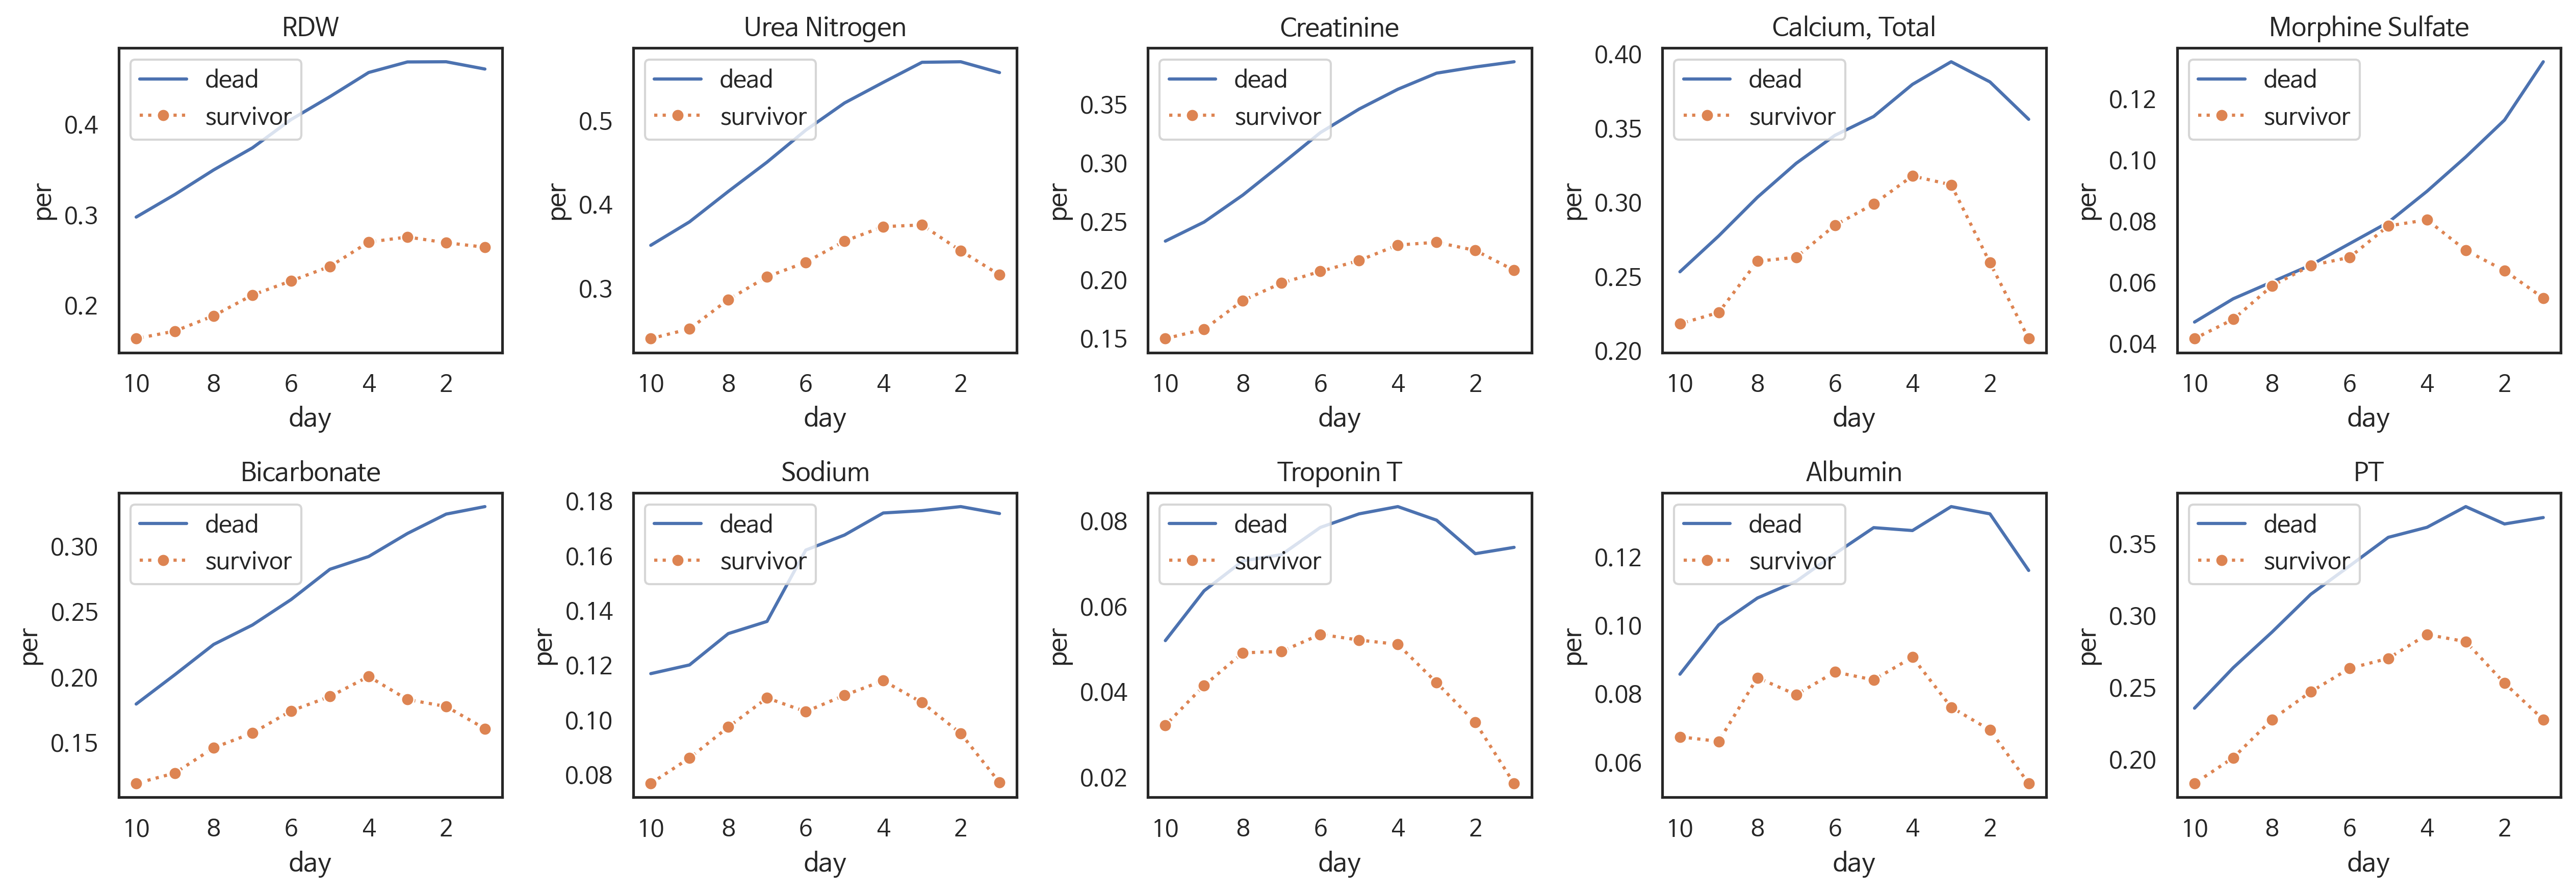

In [32]:
# TOP10 사망 마커
df1 = pd.read_csv('m1_df_3595.csv')
entropy_df = pd.read_csv('entropy_3595.csv')
m1_df_3595 = pd.merge(df1, entropy_df, how='inner', on='feature')
m1_df_3595['score'] = m1_df_3595['mean_diff'] * m1_df_3595['entropy']
m1_df_3595 = m1_df_3595.sort_values(by = 'score', ascending = False)

m1_df_3595
d_3595 = list(m1_df_3595['feature'][:10]) 
absum(d_3595)

[63323026201,
 50861,
 8084199,
 51249,
 409490234,
 55390000401,
 338070341,
 224275,
 50878,
 574705050]

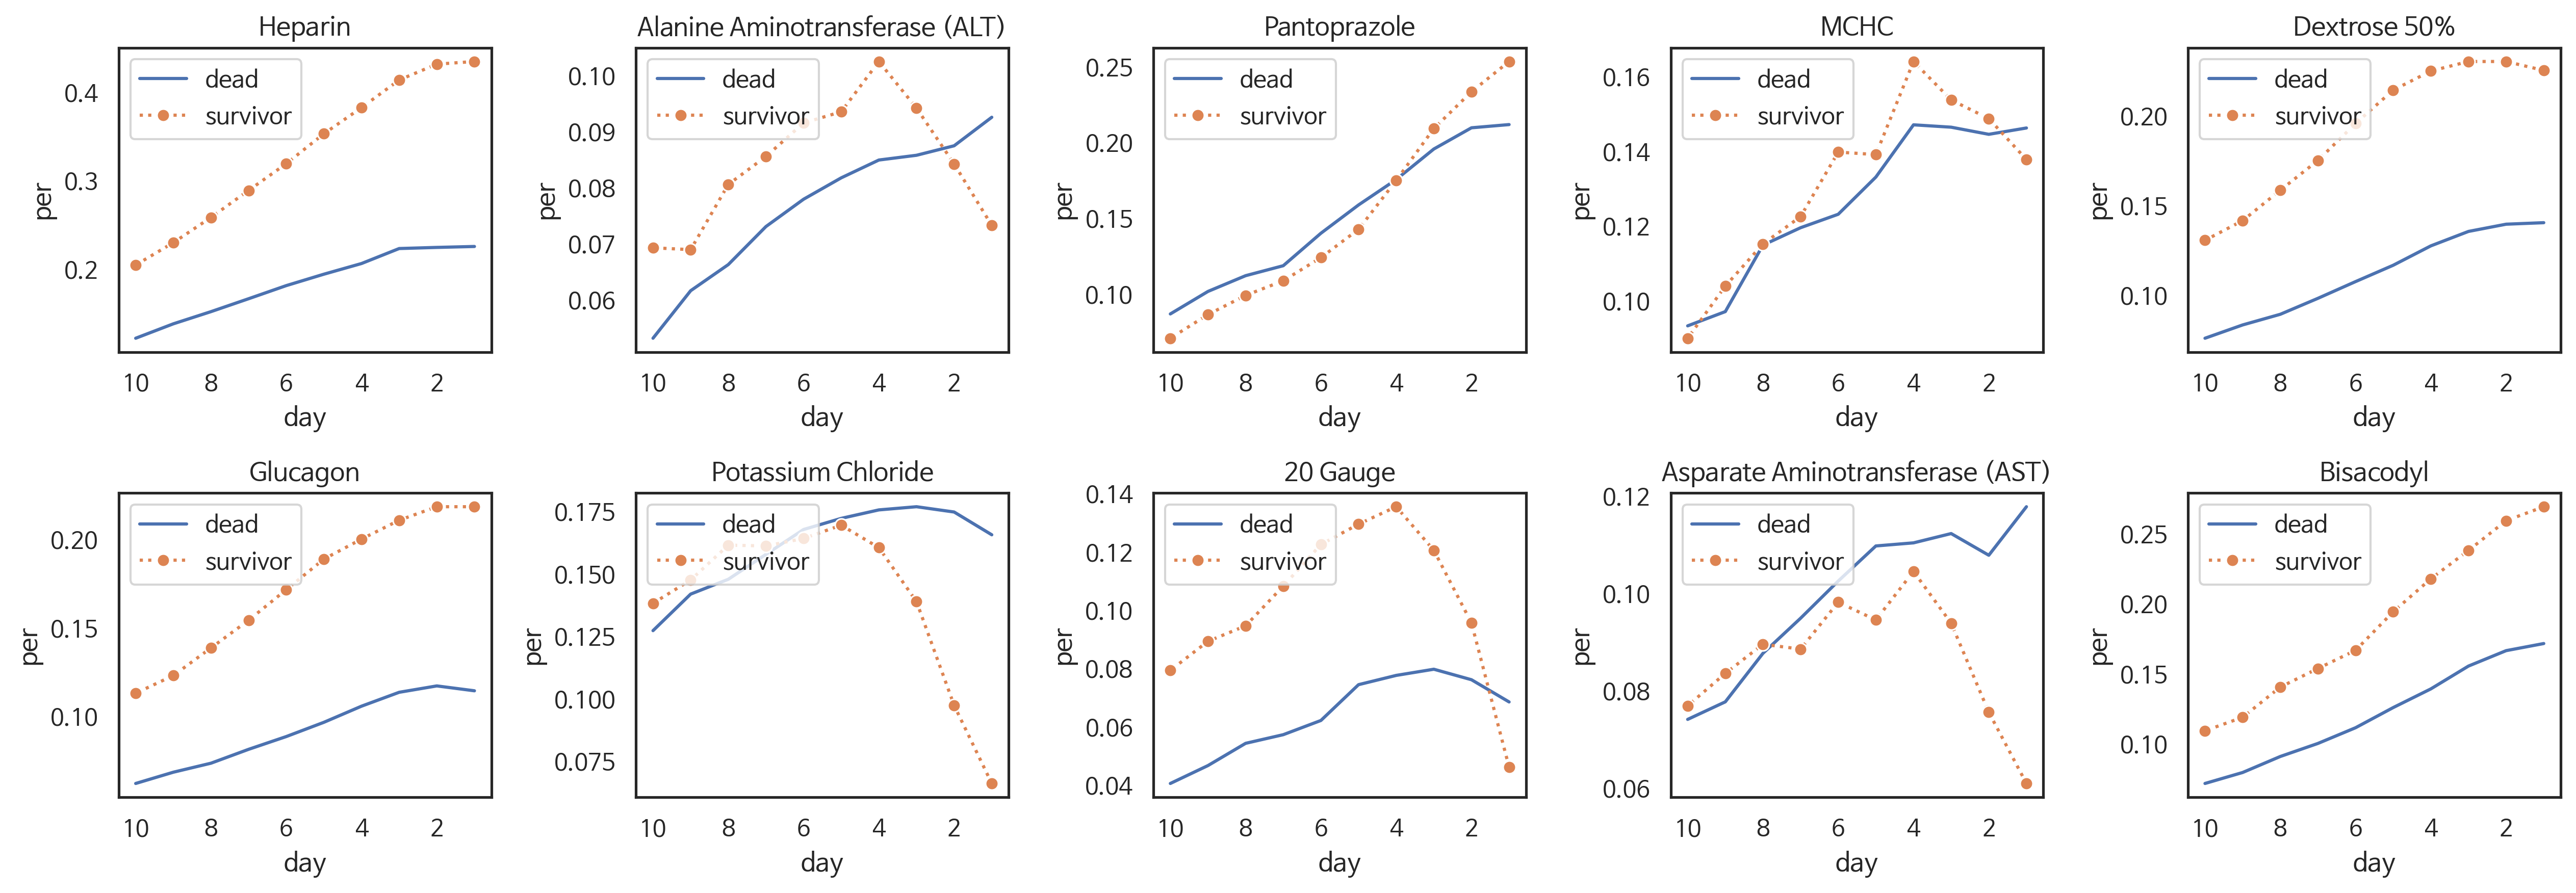

In [33]:
# TOP10 생존 마커
s_3595 = list(m1_df_3595['feature'][-11:][::-1]) 
s_3595.remove(0)
s_3595
absum(s_3595)

## x_(7727, 10, 4068)

array([    51277,     51006,     50912, 409176230,     50882,     50893,
           50983,     51003,     50862,     51274])

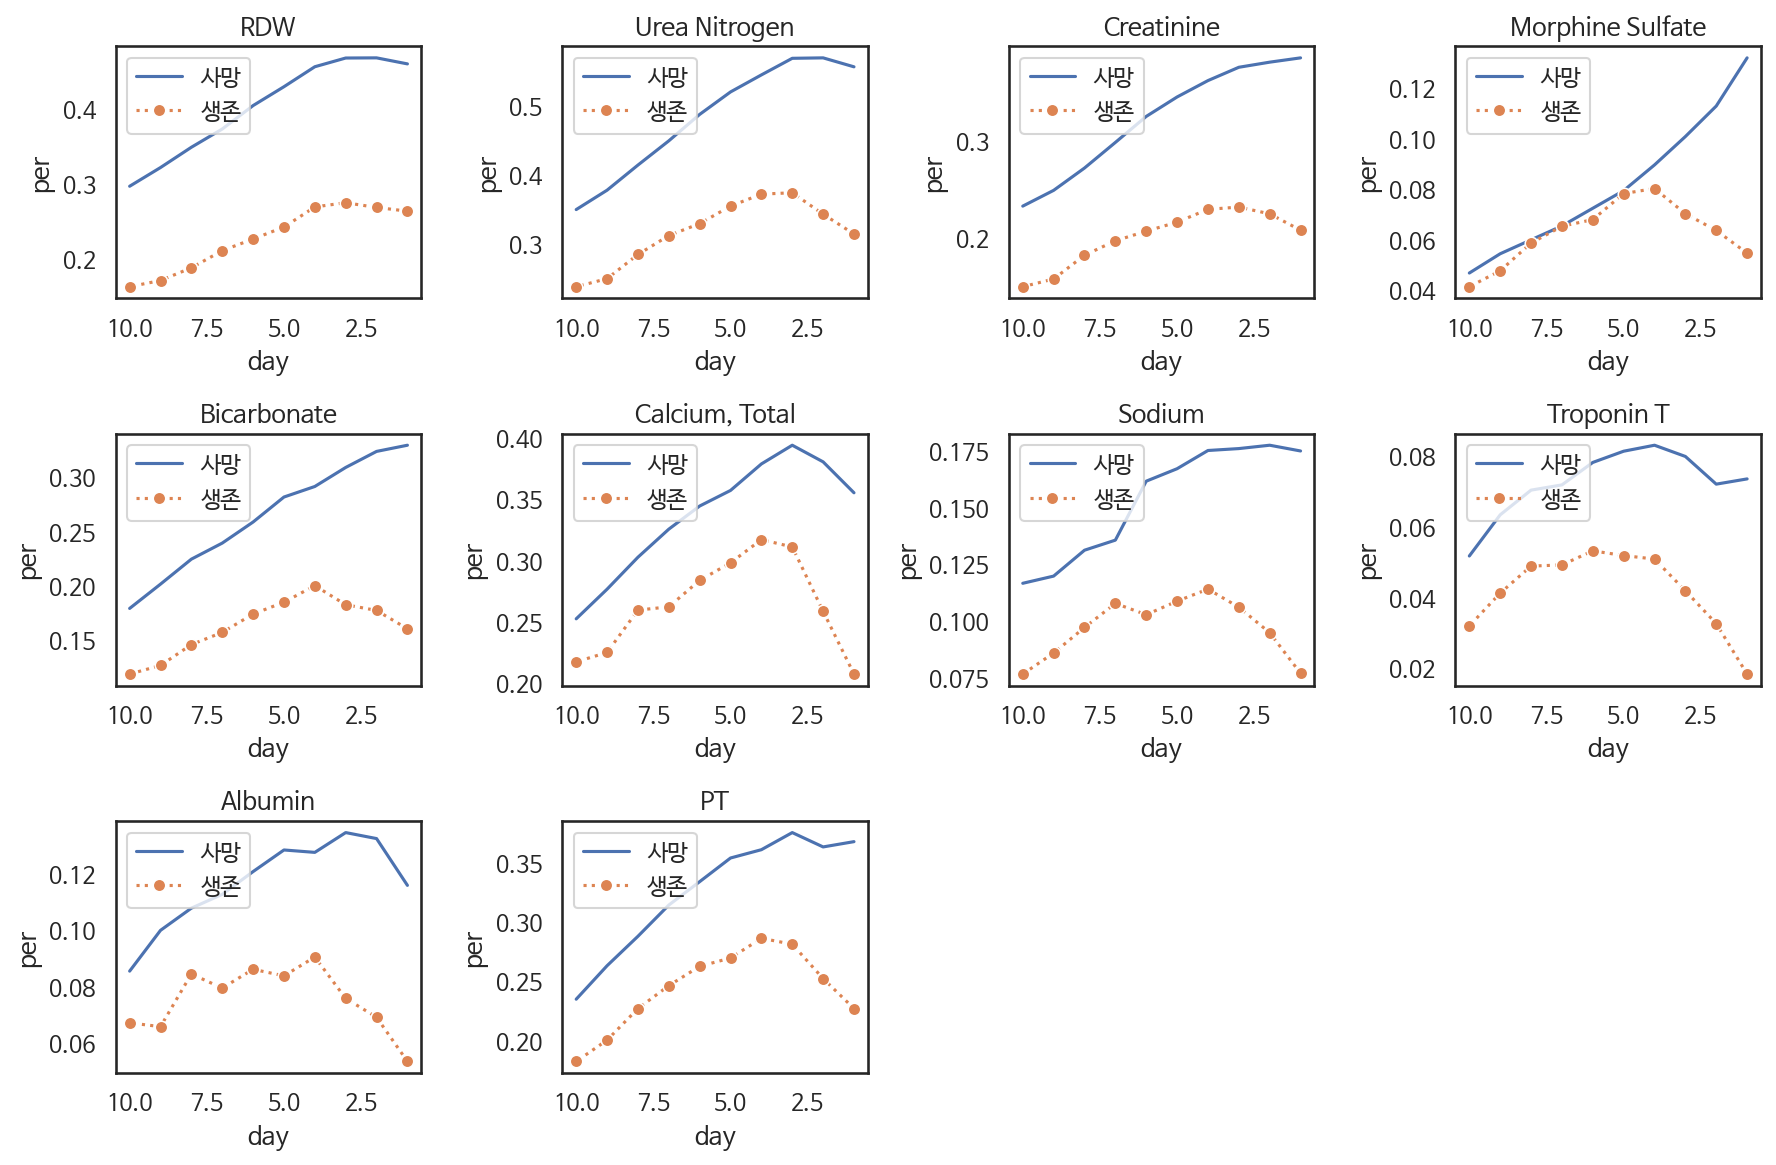

In [18]:
d_4068 = m1_df_4068['feature'][:10].values # TOP10 사망 마커
d_4068
absum(d_4068)

[63323026201,
 50861,
 8084199,
 409490234,
 51249,
 55390000401,
 338070341,
 50878,
 574705050,
 224275]

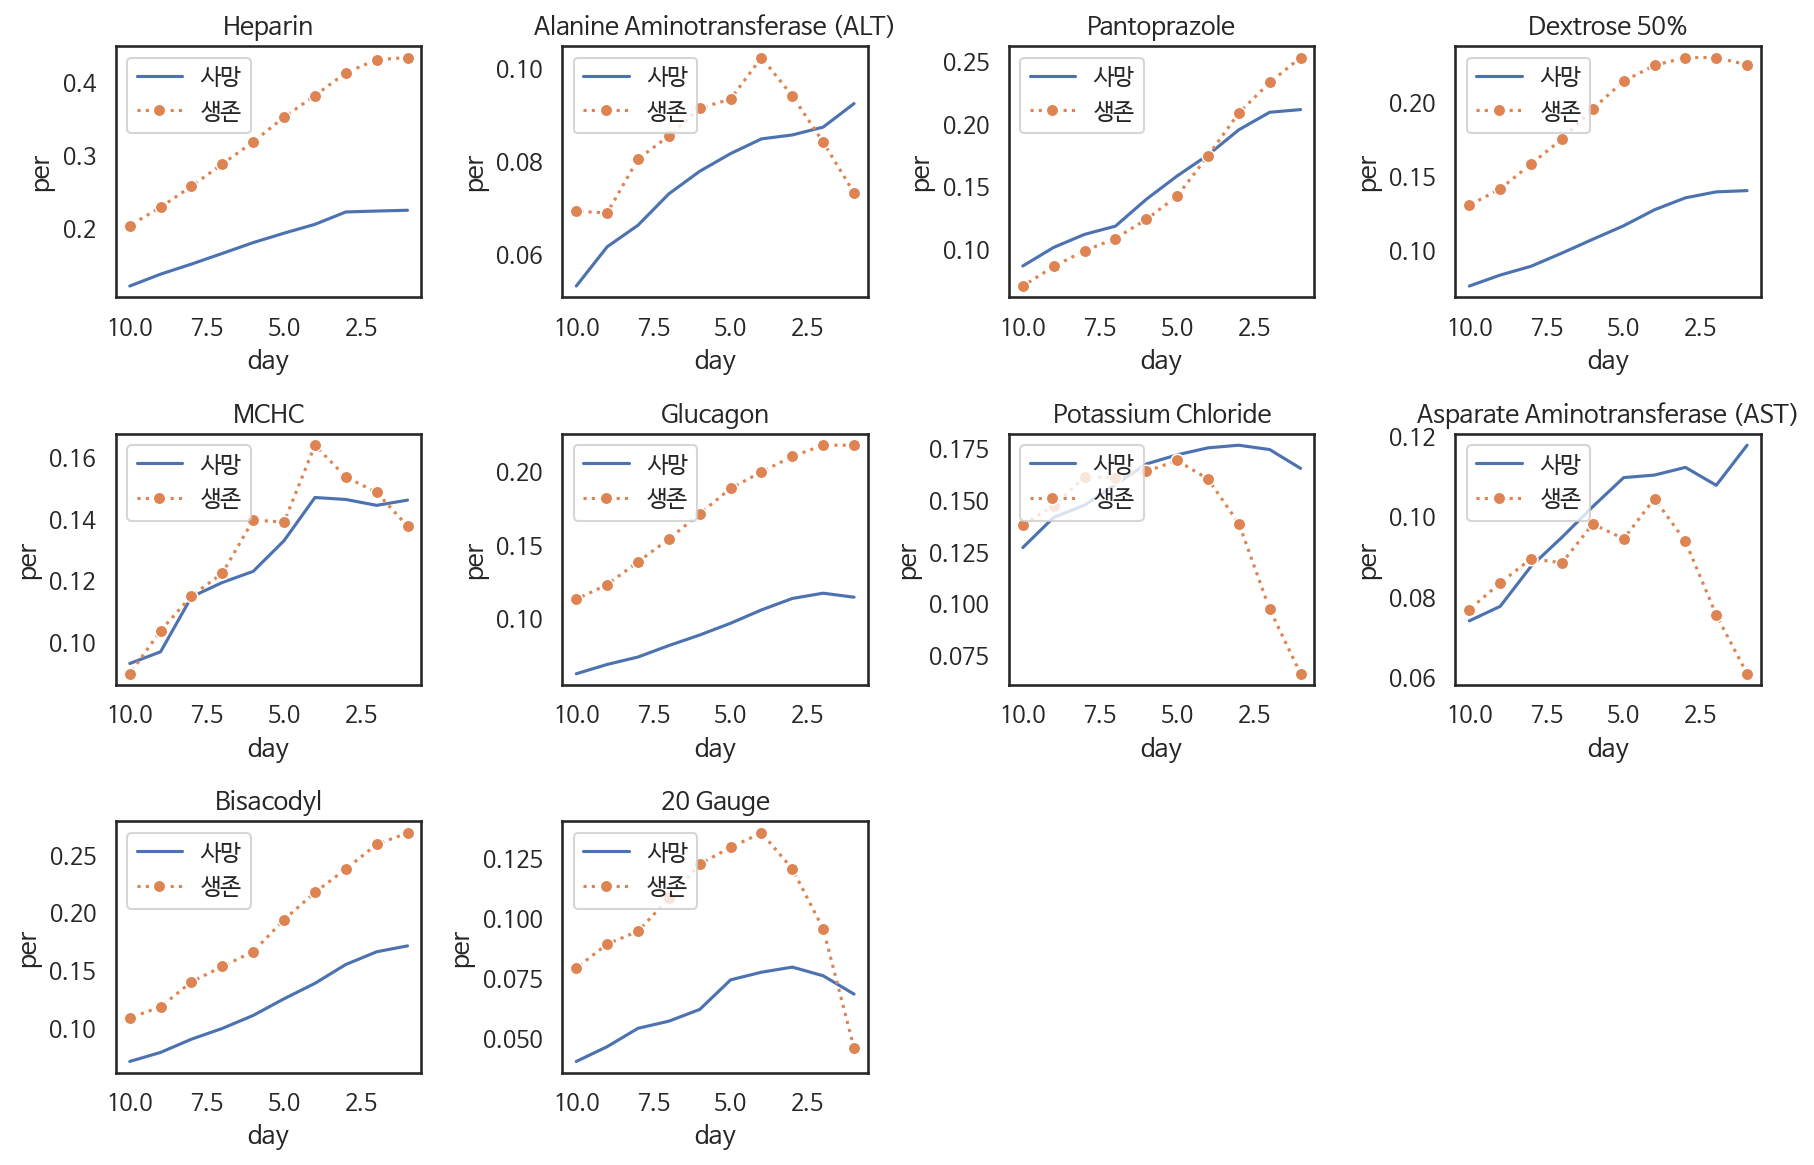

In [24]:
s_4068 = list(m1_df_4068['feature'][-11:][::-1]) # TOP10 생존 마커
s_4068.remove(0)
s_4068
absum(s_4068)